In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from collections import deque, namedtuple
import random
import datetime
import itertools
import os
from google.colab import files
import shutil
import matplotlib.pyplot as plt

Mounted at /content/drive


In [36]:

# Policy network
class Policy(nn.Module):
    def __init__(self, observation_space, action_space):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(observation_space, 256)
        # self.hidden_layer = nn.Linear(256,128)
        self.output_layer = nn.Linear(256, action_space)

    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)

        #relu activation
        x = F.relu(x)

        # x = self.hidden_layer(x)

        # #relu activation
        # x = F.relu(x)

        #actions
        actions = self.output_layer(x)

        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)

        return action_probs

In [37]:
# Value network for baseline
class Value(nn.Module):
    #Takes in state
    def __init__(self, observation_space):
        super(Value, self).__init__()

        self.input_layer = nn.Linear(observation_space, 256)
        # self.hidden_layer = nn.Linear(256,128)

        self.output_layer = nn.Linear(256, 1)

    def forward(self, x):
        #input layer
        x = self.input_layer(x)

        #activiation relu
        x = F.relu(x)

        # x = self.hidden_layer(x)

        # #relu activation
        # x = F.relu(x)

        #get state value
        state_value = self.output_layer(x)

        return state_value

In [38]:
LR=5e-3

In [39]:

class MC_REINFORCE_Agent:
    def __init__(self, env_name, use_baseline=False, seed=None):
        self.env=env
        self.policy = Policy(self.env.observation_space.shape[0], self.env.action_space.n)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=LR)
        self.use_baseline = use_baseline
        if seed is not None:
            torch.manual_seed(seed)
        if self.use_baseline:
            self.value_network = Value(self.env.observation_space.shape[0])
            self.value_optimizer = optim.Adam(self.value_network.parameters(), lr=LR)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.policy(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    def calculate_discounted_returns(self, rewards, gamma=0.99):
        R = 0
        discounted_returns = []
        for r in rewards[::-1]:
            R = r + gamma * R
            discounted_returns.insert(0, R)
        return discounted_returns

    def update_policy(self, discounted_returns, log_probs, baseline_values=None):
        returns = torch.tensor(discounted_returns)
        log_probs_tensor = torch.stack(log_probs)  # Convert list of tensors to a tensor

        if self.use_baseline:
            baseline_values = torch.tensor(baseline_values)
            advantages = returns - baseline_values
            policy_loss = (-log_probs_tensor * advantages).mean()

        else : policy_loss = (-log_probs_tensor * returns).sum()

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

    def update_baseline(self, states, rewards):
        states = torch.tensor(states).float()
        rewards_tensor = torch.tensor(rewards).float()  # Convert rewards to a PyTorch tensor
        with torch.no_grad():
            next_state_values = self.value_network(states).squeeze(1)
            td_targets = rewards_tensor + 0.99 * next_state_values
        predicted_values = self.value_network(states).squeeze(1)
        value_loss = F.mse_loss(predicted_values, td_targets)

        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()


    def train(self, episodes):
        scores = []

        for episode in range(episodes):
            state = self.env.reset()
            done = False
            rewards = []
            log_probs = []
            states = []  # For TD(0) update
            baseline_values = []

            while not done:
                action, log_prob = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                states.append(state)  # For TD(0) update
                state = next_state

            if self.use_baseline:
                # Update baseline values using TD(0)
                self.update_baseline(states, rewards)
                # Get baseline values for the current episode
                with torch.no_grad():
                    states_tensor = torch.tensor(states).float()
                    baseline_values = self.value_network(states_tensor).squeeze().tolist()

            discounted_returns = self.calculate_discounted_returns(rewards)
            self.update_policy(discounted_returns, log_probs, baseline_values)
            scores.append(np.array(rewards).sum())
            if episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores)))

        return scores


    def evaluate(self, episodes):
        rewards = []
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            episode_reward = 0

            while not done:
                action, _ = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                state = next_state

            rewards.append(episode_reward)

        return sum(rewards) / episodes


In [40]:
# Example usage
env = gym.make('CartPole-v1')
env.seed(0)
agent_without_baseline = MC_REINFORCE_Agent('CartPole-v1', use_baseline=False,seed=6)
# scores_1 =agent_without_baseline.train(1000)
agent_with_baseline = MC_REINFORCE_Agent('CartPole-v1', use_baseline=True,seed=11)
scores_2 = agent_with_baseline.train(1000)

#10

# Plot the scores
plt.plot(scores_1, label='Type-1')
plt.plot(scores_2, label='Type-2')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('MC Reinforce Training')
plt.legend()
plt.show()

Episode 0	Average Score: 15.00
Episode 100	Average Score: 56.66
Episode 200	Average Score: 47.75


KeyboardInterrupt: 

Episode 0	Average Score: 9.00
Episode 100	Average Score: 43.53
Episode 200	Average Score: 35.64
Episode 300	Average Score: 39.09
Episode 400	Average Score: 47.60
Episode 500	Average Score: 48.91
Episode 600	Average Score: 49.45
Episode 700	Average Score: 47.54
Episode 800	Average Score: 47.29
Episode 900	Average Score: 49.60
Episode 0	Average Score: 15.00
Episode 100	Average Score: 40.20
Episode 200	Average Score: 45.37
Episode 300	Average Score: 45.78
Episode 400	Average Score: 48.44
Episode 500	Average Score: 54.22
Episode 600	Average Score: 53.58
Episode 700	Average Score: 54.67
Episode 800	Average Score: 59.00
Episode 900	Average Score: 59.02
Episode 0	Average Score: 11.00
Episode 100	Average Score: 10.25
Episode 200	Average Score: 19.09
Episode 300	Average Score: 33.14
Episode 400	Average Score: 40.77
Episode 500	Average Score: 44.28
Episode 600	Average Score: 47.66
Episode 700	Average Score: 48.66
Episode 800	Average Score: 48.44
Episode 900	Average Score: 47.72
Episode 0	Average

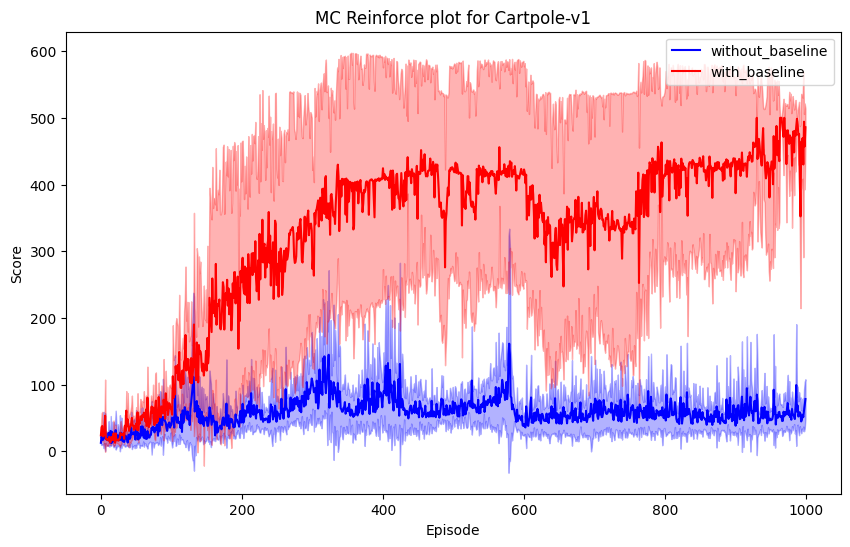

In [49]:
def plot_mean_and_variance(scores1, scores2):
    mean1 = np.mean(scores1, axis=0)
    std1 = np.std(scores1, axis=0)
    mean2 = np.mean(scores2, axis=0)
    std2 = np.std(scores2, axis=0)
    plt.plot(mean1, label='without_baseline', color='b')
    plt.fill_between(range(len(mean1)), mean1-std1, mean1+std1, color='b', alpha=0.3)
    plt.plot(mean2, label='with_baseline', color='r')
    plt.fill_between(range(len(mean2)), mean2-std2, mean2+std2, color='r', alpha=0.3)

env = gym.make('CartPole-v1')
env.seed(0)
returns1 = []
returns2 = []

# Plot episodic return versus episodic number for both types
plt.figure(figsize=(10, 6))
# for idx, update_type in enumerate(['without baseline', 'with baseline']):
    # BUFFER_SIZE, BATCH_SIZE, LR, UPDATE_EVERY  =  best_hyperparameters[update_type]['BUFFER_SIZE'], best_hyperparameters[update_type]['BATCH_SIZE'], best_hyperparameters[update_type]['LR'],best_hyperparameters[update_type]['UPDATE_EVERY']
    # returns = []
for seed in [0,1,6,3,11]:
  # if (idx == 0) :
  agent = MC_REINFORCE_Agent('CartPole-v1', use_baseline=False, seed = seed)
  scores = agent.train(1000)
  returns1.append(scores)
  # else :
for seed in [0,1,6,3,11]:
  agent = MC_REINFORCE_Agent('CartPole-v1', use_baseline=True,  seed = seed)
  scores = agent.train(1000)
  returns2.append(scores)


# plot_mean_and_variance(returns, label=f'MC-Reinforce : {update_type}', color='blue' if update_type == 'without baseline' else 'red')
plot_mean_and_variance(returns1,returns2)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('MC Reinforce plot for Cartpole-v1')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


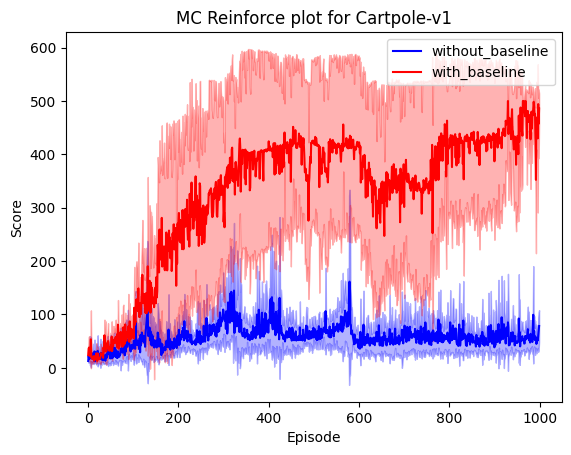

In [50]:
plot_mean_and_variance(returns1,returns2)

plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('MC Reinforce plot for Cartpole-v1')
plt.legend()
plt.show()

In [45]:
len(returns)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5

In [46]:
def plot_mean_and_variance(scores1, scores2):
    mean1 = np.mean(scores1, axis=0)
    std1 = np.std(scores1, axis=0)
    mean2 = np.mean(scores2, axis=0)
    std2 = np.std(scores2, axis=0)
    plt.plot(mean1, label='without_baseline', color='b')
    plt.fill_between(range(len(mean1)), mean1-std1, mean1+std1, color='b', alpha=0.3)
    plt.plot(mean2, label='with_baseline', color='r')
    plt.fill_between(range(len(mean2)), mean2-std2, mean2+std2, color='r', alpha=0.3)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
returns = []